In [170]:
"""
Purpose: To read through Fabian's code and understand it plus the differences between mine and his
    to see if I can recreate it

"""

"\nPurpose: To read through Fabian's code and understand it plus the differences between mine and his\n    to see if I can recreate it\n\n"

In [171]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [172]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns

import datajoint as dj
from funconnect import connectomics as cncs, ta3, nda
from funconnect.connectomics import *
from funconnect import nda
import numpy as np
import pandas as pd
import pycircstat as circ
cncs.schema.spawn_missing_classes()

/usr/local/lib/python3.6/dist-packages/datajoint/connection.py:150: UserWarning: Mysql server has gone away. Reconnecting to the server.
  warnings.warn("Mysql server has gone away. Reconnecting to the server.")


In [173]:
SharedInput() & "segment_id=694582" & "segment_b=421208"
SharedInput() & "segment_id=421208" & "segment_b=694582"

segmentation segmentation id,segment_id segment id unique within each Segmentation,shared_input_type,segment_b segment id unique within each Segmentation,n_seg_shared number of shared segments


# Orientation tuning

Set some parameters for the analysis

In [174]:
#defines how to find the "tuned" segments of the orientation
is_tuned = 'von_r2>0.05 and von_pvalue<0.05'
dori_resolution = np.pi / 2 / 4 #setting the width size of the bins to be 22.5 degrees
rad2deg = 180/np.pi
bin_edges = np.linspace(0, np.pi,9) #creates 8 bins between boundaries between 0 and pi

# turns all of the bin edges into degrees with no decimal
be = list(['{:.0f}'.format(ee) for ee in [np.round(e * rad2deg) for e in bin_edges]])
#creates the bin boundary markings with [low - high]
bin_labels = list(zip(be[:-1], be[1:]))

#calculates the bin centers
bin_centers = np.round((bin_edges[1:] + bin_edges[:-1])/2 * rad2deg, decimals=2) 

In [175]:
bin_labels

[('0', '22'),
 ('22', '45'),
 ('45', '68'),
 ('68', '90'),
 ('90', '112'),
 ('112', '135'),
 ('135', '158'),
 ('158', '180')]

Massage the relations

In [176]:
bin_centers

array([ 11.25,  33.75,  56.25,  78.75, 101.25, 123.75, 146.25, 168.75])

In [177]:
nda.VonMises()

scan_idx scan ID,segmentation segmentation id,segment_id segment id unique within each Segmentation,von_r2 r-squared explaned by vonMises fit,von_pref preferred directions,von_base von mises base value,von_amp1 amplitude of first peak,von_amp2 amplitude of second peak,von_sharp sharpnesses,von_pvalue p-value by shuffling (nShuffles = 1e4)
2,1,694582,0.0390474,0.0879617,0.00519619,0.0612943,0.0331063,46.3828,0.0214895
2,1,961113,0.0247101,3.63509,2.88523e-05,0.0328841,0.0227009,7.17096,0.142429
2,1,1519148,0.0358466,1.23557,0.00113802,0.0391052,0.00115531,9.69029,0.0554725
2,1,2450307,0.0271941,2.4022,0.00410094,0.0374917,0.0230603,46.3828,0.143429
2,1,2589588,0.053372,3.02107,0.00165716,0.0787312,0.0374586,26.5923,0.006497
2,1,3813916,0.0578909,2.90859,0.017539,0.139912,0.0,16.2428,0.0014995
2,1,5386310,0.0710836,2.6053,0.000644453,0.215864,0.108693,10.2717,0.002499
2,1,8795711,0.0246964,5.55608,0.00511216,0.0724953,0.0,46.3828,0.319341
2,1,10031716,0.0158782,5.61813,0.00751124,0.0565218,0.0,31.8762,0.629186
2,1,10914339,0.0799213,3.13328,0.0113467,0.297867,0.169138,11.2455,0.002499


In [178]:
nda.VonMises.describe() 
print("hello")

"""
von_r2 = r2 from vonMises fit
von_pref = prefered direction
von_amp1  = amplitude of first peak
von_amp2 = amplitude of second peak
von_pvalue = p-value by shuffling

"""

# directional tuning
-> nda.Spike
---
von_r2               : float                        # r-squared explaned by vonMises fit
von_pref             : float                        # preferred directions
von_base             : float                        # von mises base value
von_amp1             : float                        # amplitude of first peak
von_amp2             : float                        # amplitude of second peak
von_sharp            : float                        # sharpnesses
von_pvalue           : float                        # p-value by shuffling (nShuffles = 1e4)

hello


'\nvon_r2 = r2 from vonMises fit\nvon_pref = prefered direction\nvon_amp1  = amplitude of first peak\nvon_amp2 = amplitude of second peak\nvon_pvalue = p-value by shuffling\n\n'

In [179]:
tuned_rel = nda.VonMises() & is_tuned
segment_ids_tuned = tuned_rel.fetch("segment_id")
len(np.unique(segment_ids_tuned))

84

In [180]:
best_r2 = dj.U('segment_id').aggr(tuned_rel, best_r2='max(von_r2)')
best_r2

segment_id segment id unique within each Segmentation,best_r2 calculated attribute
942272,0.0936105
961113,0.102706
2228043,0.339064
2589588,0.053372
3152488,0.0653267
3813916,0.0578909
3841528,0.0710342
3851918,0.0765172
5386310,0.107235
7665318,0.0625932


In [181]:
pref_rel = (tuned_rel * best_r2) & 'von_r2 >= best_r2'
pref_rel

scan_idx scan ID,segmentation segmentation id,segment_id segment id unique within each Segmentation,von_r2 r-squared explaned by vonMises fit,von_pref preferred directions,von_base von mises base value,von_amp1 amplitude of first peak,von_amp2 amplitude of second peak,von_sharp sharpnesses,von_pvalue p-value by shuffling (nShuffles = 1e4),best_r2 calculated attribute
2,1,2589588,0.053372,3.02107,0.00165716,0.0787312,0.0374586,26.5923,0.006497,0.053372
2,1,3813916,0.0578909,2.90859,0.017539,0.139912,0.0,16.2428,0.0014995,0.0578909
2,1,10914339,0.0799213,3.13328,0.0113467,0.297867,0.169138,11.2455,0.002499,0.0799213
2,1,16809519,0.236849,4.00482,0.00729216,0.537001,0.32923,19.5817,0.0005,0.236849
2,1,23410728,0.118081,2.10778,0.0550229,1.0047,0.292185,5.85615,0.0005,0.118081
2,1,27229091,0.161084,5.57486,0.00616441,0.450609,0.0902593,14.4957,0.0005,0.161084
2,1,38469670,0.198155,5.51238,0.00350638,0.232938,0.0834227,37.8783,0.0005,0.198155
2,1,51584311,0.0553313,6.28317,0.000427696,0.065726,0.0,46.3828,0.022489,0.0553313
2,1,55282126,0.301841,4.01177,0.00617098,0.715196,0.516936,20.5749,0.0005,0.301841
2,1,60064737,0.130585,2.27279,0.0280423,0.47223,0.0629194,37.7494,0.0005,0.130585


In [182]:
attrs = ['segment_a', 'segment_b', 'connection', 'n_seg_shared']

In [183]:
dj.U(*attrs) & SharedInput.proj('n_seg_shared', connection='shared_input_type', segment_a = 'segment_id')

segment_a segment id unique within each Segmentation,connection,segment_b segment id unique within each Segmentation,n_seg_shared number of shared segments
694582,all,421208,16
694582,non-perisomatic,421208,16
694582,perisomatic,421208,0
845222,all,421208,0
845222,all,694582,0
845222,non-perisomatic,421208,0
845222,non-perisomatic,694582,0
845222,perisomatic,421208,0
845222,perisomatic,694582,0
942272,all,421208,0


In [184]:
shi = (dj.U(*attrs) & SharedInput.proj('n_seg_shared', connection='shared_input_type', segment_a = 'segment_id')) + \
      (dj.U(*attrs) & SharedInput.proj('n_seg_shared', connection='shared_input_type', segment_a='segment_b', segment_b='segment_id'))
shi

segment_a segment id unique within each Segmentation,connection,segment_b segment id unique within each Segmentation,n_seg_shared number of shared segments
694582,all,421208,16
694582,non-perisomatic,421208,16
694582,perisomatic,421208,0
845222,all,421208,0
845222,all,694582,0
845222,non-perisomatic,421208,0
845222,non-perisomatic,694582,0
845222,perisomatic,421208,0
845222,perisomatic,694582,0
942272,all,421208,0


In [185]:
SharedInput.describe()
SharedInputRestriction()

-> ta3.Segment
-> SharedInputRestriction
segment_b            : bigint                       # segment id unique within each Segmentation
---
n_seg_shared         : int                          # number of shared segments



shared_input_type
all
non-perisomatic
perisomatic


In [186]:
#gets the tuned segments, comes out to be 111, but there are some repeat segment ids
tuned_rel = nda.VonMises() & is_tuned
#gets a uniqe list of segment ids with theri best von_r2 (r2 value for the von misses fit) for each
best_r2 = dj.U('segment_id').aggr(tuned_rel, best_r2='max(von_r2)')

#gets all of the tuning stats for only the unique segment ids and their best r2 entry
pref_rel = (tuned_rel * best_r2) & 'von_r2 >= best_r2'

#creating a dictionary for helping to restrict
p_cond = dict(p='n_seg_shared > 0')
# p_cond = dict(p='n_seg_shared = 10')
attrs = ['segment_a', 'segment_b', 'connection', 'n_seg_shared']
#gets table where have every connection from segment_a to segment b anf the number of n_seg_shared stacked on a 
#repeat but the ids for a and b are switched
shi = (dj.U(*attrs) & SharedInput.proj('n_seg_shared', connection='shared_input_type', segment_a = 'segment_id')) + \
      (dj.U(*attrs) & SharedInput.proj('n_seg_shared', connection='shared_input_type', segment_a='segment_b', segment_b='segment_id')) #+ \
#       (dj.U(*attrs) & SharedContactPair.proj('segment_a', 'segment_b', n_seg_shared='n_axon_shared', connection='"contact"')) + \
#       (dj.U(*attrs) & SharedContactPair.proj(segment_b='segment_a', segment_a='segment_b', n_seg_shared='n_axon_shared', connection='"contact"')) 

#creates a table with their preferred orientation for both segment A and B appended onto them
rel2 = shi  * pref_rel.proj(ori_1='von_pref',dummy='scan_idx', segment_a='segment_id') * pref_rel.proj(segment_b='segment_id', ori_2='von_pref')

In [187]:

rel2 = shi  * pref_rel.proj(ori_1='von_pref',dummy='scan_idx', segment_a='segment_id') * pref_rel.proj(segment_b='segment_id', ori_2='von_pref')
rel2

segment_a segment id unique within each Segmentation,connection,segment_b segment id unique within each Segmentation,n_seg_shared number of shared segments,dummy scan ID,segmentation segmentation id,scan_idx scan ID,ori_1 preferred directions,ori_2 preferred directions
2589588,non-perisomatic,942272,0,2,1,3,3.02107,5.08723
2589588,all,29816444,0,2,1,4,3.02107,3.82339
2589588,all,73396353,0,2,1,3,3.02107,5.51174
2589588,all,38469670,1,2,1,2,3.02107,5.51238
2589588,all,107731759,7,2,1,2,3.02107,4.12827
2589588,non-perisomatic,31134493,0,2,1,5,3.02107,0.761344
2589588,non-perisomatic,72259575,1,2,1,3,3.02107,0.664596
2589588,all,3851918,5,2,1,6,3.02107,5.79303
2589588,non-perisomatic,3851918,5,2,1,6,3.02107,5.79303
2589588,perisomatic,3851918,0,2,1,6,3.02107,5.79303


In [188]:
dummy, scan_idx  = rel2.fetch("dummy","scan_idx")

In [189]:
from collections import Counter
Counter(scan_idx),Counter(dummy)

(Counter({3: 5976, 4: 3237, 2: 7470, 5: 2739, 6: 1494}),
 Counter({2: 7470, 3: 5976, 4: 3237, 5: 2739, 6: 1494}))

In [190]:
#make sure that there are repeats
current_dict = dict(segment_b=2589588,connection = "perisomatic",segment_a=10356289,n_seg_shared=0)


rel2 & current_dict

segment_a segment id unique within each Segmentation,connection,segment_b segment id unique within each Segmentation,n_seg_shared number of shared segments,dummy scan ID,segmentation segmentation id,scan_idx scan ID,ori_1 preferred directions,ori_2 preferred directions
10356289,perisomatic,2589588,0,6,1,2,3.17413,3.02107


In [191]:
current_dict = dict(segment_a=2589588,connection = "perisomatic",segment_b=10356289,n_seg_shared=0)

rel2 & current_dict

segment_a segment id unique within each Segmentation,connection,segment_b segment id unique within each Segmentation,n_seg_shared number of shared segments,dummy scan ID,segmentation segmentation id,scan_idx scan ID,ori_1 preferred directions,ori_2 preferred directions
2589588,perisomatic,10356289,0,2,1,6,3.02107,3.17413


In [192]:
SharedInput()

segmentation segmentation id,segment_id segment id unique within each Segmentation,shared_input_type,segment_b segment id unique within each Segmentation,n_seg_shared number of shared segments
1,694582,all,421208,16
1,694582,non-perisomatic,421208,16
1,694582,perisomatic,421208,0
1,845222,all,421208,0
1,845222,all,694582,0
1,845222,non-perisomatic,421208,0
1,845222,non-perisomatic,694582,0
1,845222,perisomatic,421208,0
1,845222,perisomatic,694582,0
1,942272,all,421208,0


Fetch the dataframe and bin the orientations

In [193]:
help(circ.cdiff)

Help on function cdiff in module pycircstat.descriptive:

cdiff(alpha, beta)
    Difference between pairs :math:`x_i-y_i` around the circle,
    computed efficiently.
    
    :param alpha:  sample of circular random variable
    :param beta:   sample of circular random variable
    :return: distance between the pairs



In [194]:
#you can compute the circular difference 
v1 = np.array([np.pi,1.5*np.pi,2*np.pi,2.5*np.pi])
v2 = np.array([3*np.pi,2.5*np.pi,2*np.pi,1.5*np.pi])
#v2 = [v1[len(v1) - (k + 1)] for range(0,len(v1))]
circ.cdiff(v1,v2)
#circ.cdiff(np.pi,3.1*np.pi)


array([ 2.44929360e-16, -3.14159265e+00,  0.00000000e+00,  3.14159265e+00])

In [195]:
bin_centers

array([ 11.25,  33.75,  56.25,  78.75, 101.25, 123.75, 146.25, 168.75])

In [196]:
1.334*180/np.pi

76.43256987045181

In [197]:
12 %5

2

In [198]:
#gets the data
df = pd.DataFrame(rel2.fetch())

"""
find thes absolute difference in orientation
(have to multiply and then divide by 2 because it is orientation so only goes from 0 - 180, 
but this way we can reuse the circular function)
"""
df['dori'] = np.abs(circ.cdiff(2 * df['ori_1'], 2 * df['ori_2'])/2)
#calculates the bin of the orientation
df['bdori'] = bin_centers[(np.digitize(np.abs(circ.cdiff(2 * df['ori_1'], 2 * df['ori_2'])/2), bin_edges))-1] #bug: should be bin_centers[... -1]
#calculates the degrees of the orientation by 1) finding remainder after dividing by pi (get orientation value), multiplying by 180/pi
df['ori_1'] = (df['ori_1'] % np.pi) * rad2deg
df['ori_2'] = (df['ori_2'] % np.pi) * rad2deg

#now want to convert the orientation to bins by  degrees, convert to radians and then find remainder after pi
df['bori_1'] = bin_centers[(np.digitize((df['ori_1'] / rad2deg) % np.pi, bin_edges))-1] #bug: should be (df['ori_1'] / rad2deg) % np.pi
df['bori_2'] = bin_centers[(np.digitize((df['ori_2'] / rad2deg) % np.pi, bin_edges))-1]


In [199]:
df

,segment_a,connection,segment_b,n_seg_shared,dummy,segmentation,scan_idx,ori_1,ori_2,dori,bdori,bori_1,bori_2
0,2589588,non-perisomatic,942272,0,2,1,3,173.094561,111.476808,1.075433,56.25,168.75,101.25
1,2589588,all,29816444,0,2,1,4,173.094561,39.064110,0.802320,56.25,168.75,33.75
2,2589588,all,73396353,0,2,1,3,173.094561,135.799440,0.650923,33.75,168.75,146.25
3,2589588,non-perisomatic,113957829,2,2,1,5,173.094561,156.824851,0.283960,11.25,168.75,146.25
4,2589588,non-perisomatic,31134493,0,2,1,5,173.094561,43.621798,0.881867,56.25,168.75,33.75
5,2589588,perisomatic,70633777,0,2,1,3,173.094561,13.349765,0.353520,11.25,168.75,11.25
6,2589588,non-perisomatic,107731759,7,2,1,2,173.094561,56.532448,1.107200,56.25,168.75,56.25
7,2589588,all,3851918,5,2,1,6,173.094561,151.916170,0.369633,11.25,168.75,146.25
8,2589588,non-perisomatic,3851918,5,2,1,6,173.094561,151.916170,0.369633,11.25,168.75,146.25
9,2589588,perisomatic,3851918,0,2,1,6,173.094561,151.916170,0.369633,11.25,168.75,146.25


# Plot cumulative distributions

In [200]:
"""
This will group together all the ones that have the same connection, bdori and number of shared
segments

So goes through and finds all of the connection pairs that have the:
1) same connection type
2) same bined orientation difference
3) same number of shared segments

Condenses: 20916 --> 400 rows

"""
stuff = ['connection', 'bdori', 'n_seg_shared']

n = df.groupby(stuff)['dummy'].count().reset_index()
n

,connection,bdori,n_seg_shared,dummy
0,all,11.25,0,812
1,all,11.25,1,222
2,all,11.25,2,130
3,all,11.25,3,74
4,all,11.25,4,76
5,all,11.25,5,68
6,all,11.25,6,44
7,all,11.25,7,50
8,all,11.25,8,24
9,all,11.25,9,26


In [201]:
"""
Groups the n matrix by the connection type and binned difference in orientation

Then sums up all the number of shared segments for that group
Puts that number in each row for whatever binning group that row fell into 
(why see repeats because all of those with the same number were in the same grouping)

"""

s = n.groupby(stuff[:-1]).transform('sum')
s

,n_seg_shared,dummy
0,1799,1838
1,1799,1838
2,1799,1838
3,1799,1838
4,1799,1838
5,1799,1838
6,1799,1838
7,1799,1838
8,1799,1838
9,1799,1838


In [202]:
n

,connection,bdori,n_seg_shared,dummy
0,all,11.25,0,812
1,all,11.25,1,222
2,all,11.25,2,130
3,all,11.25,3,74
4,all,11.25,4,76
5,all,11.25,5,68
6,all,11.25,6,44
7,all,11.25,7,50
8,all,11.25,8,24
9,all,11.25,9,26


In [203]:
"""
Almost same as s but instead of total sum for each row, the incremental sum, 
sum = add all numbers in group
cumsum = add only number in group for itself and those above it 
"""

cs = n.groupby(stuff[:-1]).transform('cumsum')
cs

,n_seg_shared,dummy
0,0,812
1,1,1034
2,3,1164
3,6,1238
4,10,1314
5,15,1382
6,21,1426
7,28,1476
8,36,1500
9,45,1526


In [204]:
stuff = ['connection', 'bdori', 'n_seg_shared']
"""
This will group together all the ones that have the same connection, bdori and number of shared
segments

So goes through and finds all of the connection pairs that have the:
1) same connection type
2) same bined orientation difference
3) same number of shared segments

Condenses: 20916 --> 400 rows

"""
n = df.groupby(stuff)['dummy'].count().reset_index()

"""
Groups the n matrix by the connection type and binned difference in orientation

Then sums up all the number of shared segments for that group
Puts that number in each row for whatever binning group that row fell into 
(why see repeats because all of those with the same number were in the same grouping)

"""

s = n.groupby(stuff[:-1]).transform('sum')

"""
Almost same as s but instead of total sum for each row, the incremental sum, 
sum = add all numbers in group
cumsum = add only number in group for itself and those above it 
"""
cs = n.groupby(stuff[:-1]).transform('cumsum')
n['P'] = 1 - cs['dummy']/s['dummy'] #ratio of cum sum to total sum
n['csum'] = cs['dummy'] #saves the cumulative sum of shared segments
n['sum'] = s['dummy'] #sames the total sum of shared segments
#ratio of group sum (not cum sum) to the total sum for the grouped connection and bdori
n['prob'] = n['dummy']/s['dummy'] 
n

"""
Conclusion: Derived from all the different pairings and their n_seg_shared and binned difference in orientation
comes up with table that is grouped by connection type, binned differenc in orienation and n_seg shared
Then for each group it computes the following the:
1) How many pairings fell in that category (dummy)
2) P = 1 - (cum sum of pairings)/total sum  for that connection/bdori group
3) cumsum = number of pairings including and abover for that connection/bdori
4) sum = Number of total pairings in that group of connection/bdori
5) prob = (number of pairings in that connection/bdori/n_seg_shared group)/total number of connection in the connect/bdori group


"""

'\nConclusion: Derived from all the different pairings and their n_seg_shared and binned difference in orientation\ncomes up with table that is grouped by connection type, binned differenc in orienation and n_seg shared\nThen for each group it computes the following the:\n1) How many pairings fell in that category (dummy)\n2) P = 1 - (cum sum of pairings)/total sum  for that connection/bdori group\n3) cumsum = number of pairings including and abover for that connection/bdori\n4) sum = Number of total pairings in that group of connection/bdori\n5) prob = (number of pairings in that connection/bdori/n_seg_shared group)/total number of connection in the connect/bdori group\n\n\n'

## P(more than k shared segments| $\Delta \vartheta$)

In [205]:
n

,connection,bdori,n_seg_shared,dummy,P,csum,sum,prob
0,all,11.25,0,812,0.558215,812,1838,0.441785
1,all,11.25,1,222,0.437432,1034,1838,0.120783
2,all,11.25,2,130,0.366703,1164,1838,0.070729
3,all,11.25,3,74,0.326442,1238,1838,0.040261
4,all,11.25,4,76,0.285092,1314,1838,0.041349
5,all,11.25,5,68,0.248096,1382,1838,0.036997
6,all,11.25,6,44,0.224157,1426,1838,0.023939
7,all,11.25,7,50,0.196953,1476,1838,0.027203
8,all,11.25,8,24,0.183896,1500,1838,0.013058
9,all,11.25,9,26,0.169750,1526,1838,0.014146


In [206]:
n['k'] = n['n_seg_shared'] #just creates a new columns with the number of shared segments called k

In [207]:
# sns.set_context('notebook', font_scale=1.3) #helps set the size of graphs wherever plotting

# #categorical plot (There is some when applying the hues here)
# g = sns.catplot('bdori', 'P', data=n, kind='point', col='connection', hue='k', 
#                 hue_order=np.arange(12),  palette=sns.color_palette("GnBu_d", n_colors=12), legend=False, legend_out=True, sharey=False)
# g.set_titles('{col_name} axons')
# g.set_axis_labels(y_var='p(number of shared segments>k)', x_var=r'$\Delta \theta$')
# g
# for ax in g.axes.ravel():
#     ax.set_xticklabels(['{}°-{}°'.format(*a) for a in bin_labels], rotation=0)
# # g.axes[0,-1].legend(title='k', ncol=3)
# g.add_legend(title='k', ncol=2)

# sns.despine(trim=True)
# g.fig.subplots_adjust(bottom=.2)
# # g.fig.savefig('figures/shared_input_cumprob.png', dpi=200)
# # g.fig.savefig('figures/shared_input_cumprob.pdf')

# $\langle$ shared segments $\rangle$ as function of $\Delta \theta$

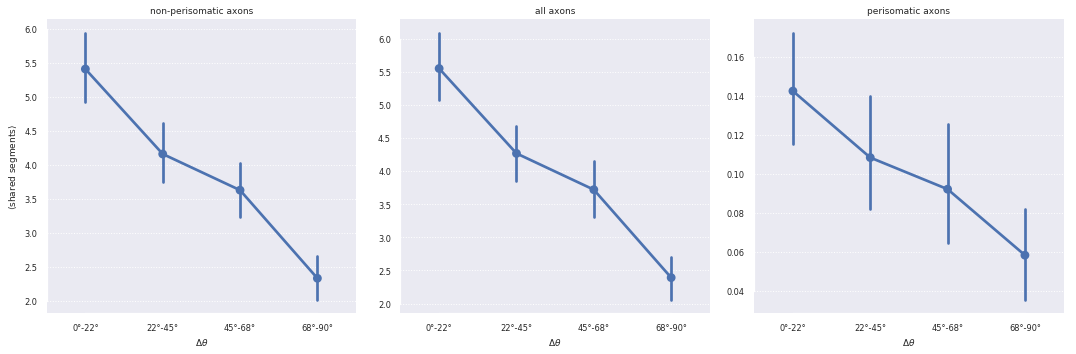

In [208]:
"""
Creates 3 different plots for each of the connection groups that compares:
1) dinned difference in orientation vs. the number of shared segments

Uses point plots which do point estimates and shows the error bars
"""

g = sns.catplot('bdori', 'n_seg_shared', data=df, kind='point', col='connection',  legend_out=True, sharey=False)
g.set_axis_labels(x_var=r'$\Delta \theta$', y_var=r'$\langle$shared segments$\rangle$')
# g.ax.set_yticks(np.arange(2,7))
# g.ax.yaxis.grid(True, linestyle=':')
for ax in g.axes.ravel():
    ax.yaxis.grid(True, linestyle=':')
    ax.set_xticklabels(['{}°-{}°'.format(*a) for a in bin_labels], rotation=0)
sns.despine(trim=True)
g.set_titles('{col_name} axons')
# g.ax.set_title('non-perisomatic axons')
g.fig.savefig('figures/average_shared_input.png', dpi=200)
g.fig.savefig('figures/average_shared_input.pdf')

# Combined plot

Get input density per postsynaptic neuron

In [209]:
#gets all of the tuning stats for only the unique segment ids and their best r2 entry
pref_rel

scan_idx scan ID,segmentation segmentation id,segment_id segment id unique within each Segmentation,von_r2 r-squared explaned by vonMises fit,von_pref preferred directions,von_base von mises base value,von_amp1 amplitude of first peak,von_amp2 amplitude of second peak,von_sharp sharpnesses,von_pvalue p-value by shuffling (nShuffles = 1e4),best_r2 calculated attribute
2,1,2589588,0.053372,3.02107,0.00165716,0.0787312,0.0374586,26.5923,0.006497,0.053372
2,1,3813916,0.0578909,2.90859,0.017539,0.139912,0.0,16.2428,0.0014995,0.0578909
2,1,10914339,0.0799213,3.13328,0.0113467,0.297867,0.169138,11.2455,0.002499,0.0799213
2,1,16809519,0.236849,4.00482,0.00729216,0.537001,0.32923,19.5817,0.0005,0.236849
2,1,23410728,0.118081,2.10778,0.0550229,1.0047,0.292185,5.85615,0.0005,0.118081
2,1,27229091,0.161084,5.57486,0.00616441,0.450609,0.0902593,14.4957,0.0005,0.161084
2,1,38469670,0.198155,5.51238,0.00350638,0.232938,0.0834227,37.8783,0.0005,0.198155
2,1,51584311,0.0553313,6.28317,0.000427696,0.065726,0.0,46.3828,0.022489,0.0553313
2,1,55282126,0.301841,4.01177,0.00617098,0.715196,0.516936,20.5749,0.0005,0.301841
2,1,60064737,0.130585,2.27279,0.0280423,0.47223,0.0629194,37.7494,0.0005,0.130585


In [210]:
#gets all of the synapses that come from an axon and synapse onto a tuned neuron and append the orientation to this table
segs = ta3.Synapse * pref_rel.proj(ori='von_pref', postsyn='segment_id') & (ta3.Neurite & dict(neurite_type='axon')).proj(presyn='segment_id')
df_segments = pd.DataFrame(segs.fetch()) #fetches the data and puts in DataFrame
df_segments['ori'] = (df_segments['ori'] % np.pi) * rad2deg #converts the orientation to degrees
#creates bins for these orientations (in degrees)
df_segments['bori'] = bin_centers[(np.digitize(df_segments['ori'] % np.pi, bin_edges))-1] 
#groups by postsyn, ori and bori and counts the number of presyns (but i think it is number of synapses)
#yes it does count the number of synapses AND NOT THE NUMBER OF PRESYNS
df_m = df_segments.groupby(['postsyn','ori','bori'])['presyn'].count().reset_index()


Get tuned neurons

In [211]:
#just gets the prefered orientation of all of the tuned cells
df_tuned = pd.DataFrame(pref_rel.proj(ori='von_pref').fetch())
#converst the preferend orientation to degrees ( and make sure that it is orientation and not direction)
df_tuned['ori'] = (df_tuned['ori'] % np.pi) * rad2deg
df_tuned

,scan_idx,segmentation,segment_id,ori
0,2,1,2589588,173.094561
1,2,1,3813916,166.649931
2,2,1,10914339,179.523720
3,2,1,16809519,49.459284
4,2,1,23410728,120.766898
5,2,1,27229091,139.415949
6,2,1,38469670,135.836109
7,2,1,51584311,179.999123
8,2,1,55282126,49.857489
9,2,1,60064737,130.221275


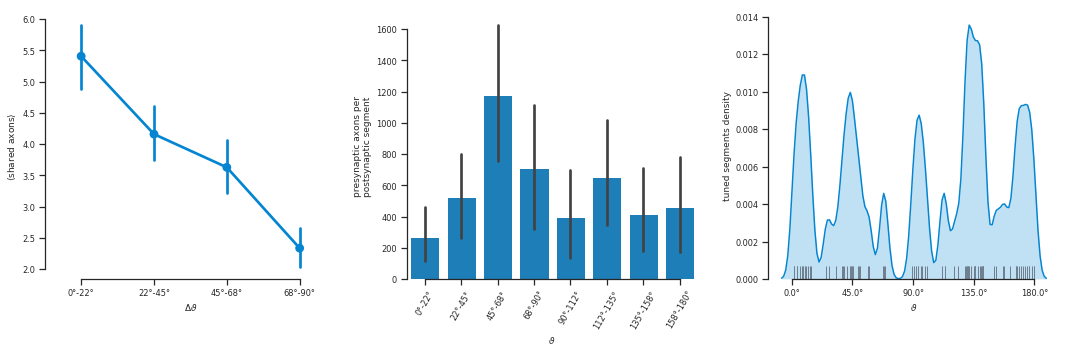

In [212]:
#creates 3 plots
with sns.axes_style('ticks'):
    fig, ax = plt.subplots(1,3, figsize=(15,5))

"""
point plot that summaries the number of bdori vs shared segments for only non-perisomatic
does point plot so calculates mean and then gives the error bar
SAME AS THE GRAPH ABOVE

"""
blue = sns.xkcd_rgb['cerulean']
sns.pointplot('bdori', 'n_seg_shared', data=df[df.connection == 'non-perisomatic'], kind='point', ax=ax[0], color=blue)
ax[0].set_xticklabels(['{}°-{}°'.format(*a) for a in bin_labels], rotation=0)



# sns.distplot(df_segments.ori, ax=ax[1], kde=False, norm_hist=False,
#             hist_kws=dict(color=blue))

"""
Graphs a bar plot of the number of synapses vs. binned direction
NOT THE NUMBER OF PRESYNS LIKE IT SAYS
"""
sns.barplot('bori', 'presyn', ax=ax[1], data=df_m, orient='vertical', color=blue)

"""
pdf of the distribution of the orientations of the unique segments
AKA what is the percentage chance that the orientation will be between particular range

Just puts a curve over the histogram
- shows the curve
- doesn't show the histogram

"""

sns.distplot(df_tuned.ori, ax=ax[2], kde=True, rug=True, 
             kde_kws=dict(bw=3, shade=True, color=blue), 
             rug_kws=dict(color='slategray'),
             hist=False)


ax[0].set_ylabel(r'$\langle$shared axons$\rangle$')
ax[0].set_xlabel(r'$\Delta \vartheta$')

xt = np.linspace(0, 180, 5)
for a in ax[1:]:
    a.set_xlabel(r'$\vartheta$')
ax[1].set_xticklabels(['{}°-{}°'.format(*a) for a in bin_labels], rotation=60)

ax[2].set_xticks(xt)
ax[2].set_xticklabels(['{}°'.format(t) for t in xt])
ax[1].set_ylabel('presynaptic axons per\npostsynaptic segment')
ax[2].set_ylabel('tuned segments density')

sns.despine(trim=True)
fig.tight_layout()
fig.savefig('figures/tuning_statistics.png', dpi=200)
fig.savefig('figures/tuning_statistics.pdf')

# Heatmap of preferred orientation and number of shared segments

In [213]:
rel2

segment_a segment id unique within each Segmentation,connection,segment_b segment id unique within each Segmentation,n_seg_shared number of shared segments,dummy scan ID,segmentation segmentation id,scan_idx scan ID,ori_1 preferred directions,ori_2 preferred directions
2589588,non-perisomatic,942272,0,2,1,3,3.02107,5.08723
2589588,perisomatic,61375585,0,2,1,3,3.02107,2.36653
2589588,all,73396353,0,2,1,3,3.02107,5.51174
2589588,non-perisomatic,94050687,5,2,1,2,3.02107,2.23921
2589588,perisomatic,99210911,0,2,1,3,3.02107,6.18547
2589588,perisomatic,37086820,0,2,1,3,3.02107,2.477
2589588,perisomatic,107731759,0,2,1,2,3.02107,4.12827
2589588,non-perisomatic,65407842,0,2,1,3,3.02107,4.75491
2589588,all,3851918,5,2,1,6,3.02107,5.79303
2589588,non-perisomatic,3851918,5,2,1,6,3.02107,5.79303


In [214]:
df

,segment_a,connection,segment_b,n_seg_shared,dummy,segmentation,scan_idx,ori_1,ori_2,dori,bdori,bori_1,bori_2
0,2589588,non-perisomatic,942272,0,2,1,3,173.094561,111.476808,1.075433,56.25,168.75,101.25
1,2589588,all,29816444,0,2,1,4,173.094561,39.064110,0.802320,56.25,168.75,33.75
2,2589588,all,73396353,0,2,1,3,173.094561,135.799440,0.650923,33.75,168.75,146.25
3,2589588,non-perisomatic,113957829,2,2,1,5,173.094561,156.824851,0.283960,11.25,168.75,146.25
4,2589588,non-perisomatic,31134493,0,2,1,5,173.094561,43.621798,0.881867,56.25,168.75,33.75
5,2589588,perisomatic,70633777,0,2,1,3,173.094561,13.349765,0.353520,11.25,168.75,11.25
6,2589588,non-perisomatic,107731759,7,2,1,2,173.094561,56.532448,1.107200,56.25,168.75,56.25
7,2589588,all,3851918,5,2,1,6,173.094561,151.916170,0.369633,11.25,168.75,146.25
8,2589588,non-perisomatic,3851918,5,2,1,6,173.094561,151.916170,0.369633,11.25,168.75,146.25
9,2589588,perisomatic,3851918,0,2,1,6,173.094561,151.916170,0.369633,11.25,168.75,146.25


In [215]:
"""
df is all of the pairings  between segments with the (pairings are given by SharedInput table)
- n_seg_shared
- orientation preference of both of them
- connection is type defined by the SharedInput table

"""

"""
What this does is restrict analysis to only connections of dendritic targets
1) groups then by their bin pairing
2) calculates the mean of the number of shared inputs

ends up being 64 long because there are 8 bins for orientation and pairwise
"""
df2 = df[df.connection == 'non-perisomatic'].groupby(['bori_1', 'bori_2'])['n_seg_shared'].mean().reset_index()
df2

,bori_1,bori_2,n_seg_shared
0,11.25,11.25,7.705128
1,11.25,33.75,2.237762
2,11.25,56.25,4.670330
3,11.25,78.75,1.871795
4,11.25,101.25,2.965812
5,11.25,123.75,5.096154
6,11.25,146.25,2.010989
7,11.25,168.75,6.328205
8,33.75,11.25,2.237762
9,33.75,33.75,0.381818


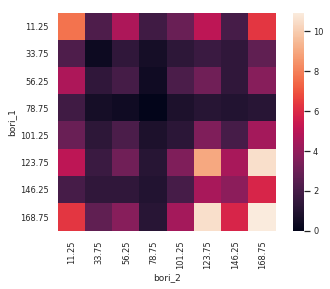

In [216]:
"""
What this does is restrict analysis to only connections of dendritic targets
1) groups then by their bin pairing
2) calculates the mean of the number of shared inputs

ends up being 64 long because there are 8 bins for orientation and pairwise
"""
df2 = df[df.connection == 'non-perisomatic'].groupby(['bori_1', 'bori_2'])['n_seg_shared'].mean().reset_index()
df2 = df2.pivot('bori_1', 'bori_2', 'n_seg_shared') #turns it into a pivot table
g = sns.heatmap(df2, square=True)

Text(81.90000000000006, 0.5, '$\\vartheta_2$')

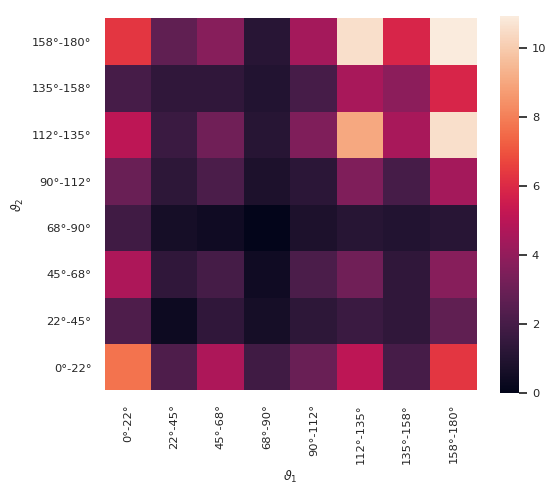

In [217]:
"""
Conclusion: The resultant graph is a pariwise comparison of the 
average number of shared input between the connections of specific orientation combination

"""

df2 = df[df.connection == 'non-perisomatic'].groupby(['bori_1', 'bori_2'])['n_seg_shared'].mean().reset_index()
df2 = df2.pivot('bori_1', 'bori_2', 'n_seg_shared')
g = sns.heatmap(df2, square=True)
g.figure.set_size_inches((6,5))
g.figure.set_dpi(100)
g.set_xticklabels(['{}°-{}°'.format(*a) for a in bin_labels])
g.set_yticklabels(['{}°-{}°'.format(*a) for a in bin_labels])
g.invert_yaxis()
g.set_xlabel(r'$\vartheta_1$')
g.set_ylabel(r'$\vartheta_2$')

# Receptive fields

Get significant receptive fields

In [218]:
"""
Things about Fabian's analysis: 
1) Non restricted to non-perisomatic
2) Double counting A --> B and B --> A



"""

"\nThings about Fabian's analysis: \n1) Non restricted to non-perisomatic\n2) Double counting A --> B and B --> A\n\n\n\n"

In [219]:
attrs = ['segment_a', 'segment_b', 'connection', 'n_seg_shared']
good_rf = 'mscore > 1.25'

cbin_edges = np.linspace(-.7, .7, 6) #setting the bin boundaries
#calculates the centers of the bins used for the receptive field
cbin_centers = np.hstack((np.nan, np.round((cbin_edges[1:] + cbin_edges[:-1])/2, decimals=2), np.nan))
#creates labels for the receptive field edges
cbin_labels = ['[{:.1f},{:.1f}]'.format(*a) for a in zip(cbin_edges[:-1], cbin_edges[1:])]

In [220]:
nda.RFScore()

scan_idx scan ID,segmentation segmentation id,segment_id segment id unique within each Segmentation,score quality score
2,1,694582,1.78066
2,1,961113,1.0903
2,1,1519148,1.11303
2,1,2450307,0.96876
2,1,2589588,1.19596
2,1,3813916,1.22167
2,1,5386310,1.30744
2,1,8795711,0.973536
2,1,10031716,1.04727
2,1,10914339,1.32449


In [221]:
"""gets the segments with the acceptable rf score and just stores their id and max mscroe
total length = 119
"""

rf_scores = dj.U('segment_id').aggr(nda.RFScore(), mscore='max(score)') & good_rf
rf_scores

segment_id segment id unique within each Segmentation,mscore calculated attribute
694582,2.09106
2228043,1.43817
2758947,1.26697
2976781,1.70648
3152488,1.52713
3205058,1.30793
5280949,1.36884
5386310,1.35013
7072200,1.42754
7256863,1.3424


In [222]:
# shi = (dj.U(*attrs) & PostSynapticPairAxonalInput.proj(n_seg_shared='n_seg_shared/n_seg_union', connection='"non-perisomatic"', 
#                                                        segment_a = 'segment_id')) + \
#       (dj.U(*attrs) & PostSynapticPairAxonalInput.proj(n_seg_shared='n_seg_shared/n_seg_union', connection='"non-perisomatic"', 
#                                                        segment_a='segment_b', segment_b='segment_id'))# + \
# crel = shi * RFCorrelation.Pair().proj('rf_corr_coef', segment_a='segment_id', segment_b='other_seg') * \
#     pref_rel.proj(ori_1='von_pref',dummy='scan_idx', segment_a='segment_id') * pref_rel.proj(segment_b='segment_id', ori_2='von_pref') * \
#     rf_scores.proj(score_a='mscore', segment_a='segment_id') * rf_scores.proj(score_b='mscore', segment_b='segment_id')

Get all *tuned* neurons with *well scoring RFs* and get their pairwise shared input. 

In [223]:
RFCorrelation.Pair()#has an rf_correlation number

segmentation segmentation id,segment_id segment id unique within each Segmentation,other_seg segment id unique within each Segmentation,rf_corr_coef correlation coefficient between two cells
1,421208,421208,1.0
1,421208,694582,0.310056
1,421208,845222,0.176162
1,421208,942272,-0.0204052
1,421208,961113,0.336671
1,421208,989772,0.0110606
1,421208,1160370,0.191868
1,421208,1305767,0.0165916
1,421208,1519148,-0.159337
1,421208,1644549,-0.157866


In [224]:
"""gets table where have every connection from segment_a to segment b anf the number of n_seg_shared stacked on a 
repeat but the ids for a and b are switched  """
shi = (dj.U(*attrs) & SharedInput.proj('n_seg_shared', connection='shared_input_type', segment_a = 'segment_id')) + \
      (dj.U(*attrs) & SharedInput.proj('n_seg_shared', connection='shared_input_type', segment_a='segment_b', segment_b='segment_id'))# + \
#       (dj.U(*attrs) & SharedContactPair.proj('segment_a', 'segment_b', n_seg_shared='n_axon_shared', connection='"contact"')) + \
#       (dj.U(*attrs) & SharedContactPair.proj(segment_b='segment_a', segment_a='segment_b', n_seg_shared='n_axon_shared', connection='"contact"')) 

""" takes all of the possible shared input combinations:
1) gets this correlation table and renames seg a and b and uses that to restrict the shared input combinations and attach the rf correlation
2) Further restricts to only those TUNED with prefered orientation (and adds on the orientation for a and b)
3) Restrict to only significant rective fields for both segment A and B by DOES NOT ATTACH THE RF score


"""
crel = shi * RFCorrelation.Pair().proj('rf_corr_coef', segment_a='segment_id', segment_b='other_seg') * \
    pref_rel.proj(ori_1='von_pref',dummy='scan_idx', segment_a='segment_id') * pref_rel.proj(segment_b='segment_id', ori_2='von_pref') * \
    rf_scores.proj(segment_a='segment_id') * rf_scores.proj(segment_b='segment_id')

In [225]:
#crel & "segment_a=10914339" & "segment_b=70633777"
#crel & "segment_a=70633777" & "segment_b=10914339"
#crel & "n_seg_shared>11"
crel & "segment_a=10914339" & "segment_b=48234238"

segment_a segment id unique within each Segmentation,connection,segment_b segment id unique within each Segmentation,n_seg_shared number of shared segments,segmentation segmentation id,dummy scan ID,scan_idx scan ID,rf_corr_coef correlation coefficient between two cells,ori_1 preferred directions,ori_2 preferred directions
10914339,non-perisomatic,48234238,33,1,2,4,0.0554095,3.13328,6.13613
10914339,perisomatic,48234238,0,1,2,4,0.0554095,3.13328,6.13613
10914339,all,48234238,33,1,2,4,0.0554095,3.13328,6.13613


In [226]:
crel & "segment_a=48234238" & "segment_b=10914339"

segment_a segment id unique within each Segmentation,connection,segment_b segment id unique within each Segmentation,n_seg_shared number of shared segments,segmentation segmentation id,dummy scan ID,scan_idx scan ID,rf_corr_coef correlation coefficient between two cells,ori_1 preferred directions,ori_2 preferred directions
48234238,all,10914339,33,1,4,2,0.0554095,6.13613,3.13328
48234238,non-perisomatic,10914339,33,1,4,2,0.0554095,6.13613,3.13328
48234238,perisomatic,10914339,0,1,4,2,0.0554095,6.13613,3.13328


In [227]:
"""****** DON'T DOUBLE COUNT BECAUSE IT IS RESTRICTED BY RFCorrelation SO SHOULDN'T HAVE REPEATS THERE"""

"****** DON'T DOUBLE COUNT BECAUSE IT IS RESTRICTED BY RFCorrelation SO SHOULDN'T HAVE REPEATS THERE"

In [228]:
cdf = pd.DataFrame(crel.fetch())

In [229]:
#gets the bins of the correlations of the receptive fields
cdf['bcorr'] = cbin_centers[(np.digitize(cdf['rf_corr_coef'], cbin_edges))]
#makes the number of shared segments as floats
cdf['n_seg_shared'] = np.array(cdf['n_seg_shared']).astype(float)
#makes the bins of the corelation of the receptive fields as floats
cdf['bcorr'] = np.array(cdf['bcorr']).astype(float)



In [230]:
cbin_centers

array([  nan, -0.56, -0.28, -0.  ,  0.28,  0.56,   nan])

In [231]:
cbin_edges

array([-0.7 , -0.42, -0.14,  0.14,  0.42,  0.7 ])

In [232]:
cdf #this checks that the bins are being correctly applied

,segment_a,connection,segment_b,n_seg_shared,segmentation,dummy,scan_idx,rf_corr_coef,ori_1,ori_2,bcorr
0,10914339,non-perisomatic,110137680,5.0,1,2,3,0.116995,3.13328,1.639360,-0.00
1,10914339,perisomatic,110137680,0.0,1,2,3,0.116995,3.13328,1.639360,-0.00
2,10914339,all,110137680,5.0,1,2,3,0.116995,3.13328,1.639360,-0.00
3,10914339,perisomatic,57781491,0.0,1,2,4,0.214111,3.13328,0.445190,0.28
4,10914339,all,57781491,3.0,1,2,4,0.214111,3.13328,0.445190,0.28
5,10914339,non-perisomatic,57781491,3.0,1,2,4,0.214111,3.13328,0.445190,0.28
6,10914339,all,93259520,34.0,1,2,4,-0.413310,3.13328,5.427040,-0.28
7,10914339,non-perisomatic,93259520,31.0,1,2,4,-0.413310,3.13328,5.427040,-0.28
8,10914339,perisomatic,93259520,3.0,1,2,4,-0.413310,3.13328,5.427040,-0.28
9,10914339,non-perisomatic,18833086,53.0,1,2,5,-0.301073,3.13328,5.895230,-0.28


In [233]:
bin_centers

array([ 11.25,  33.75,  56.25,  78.75, 101.25, 123.75, 146.25, 168.75])

In [234]:
1.383363*rad2deg

79.26086143455609

In [235]:
bin_edges*rad2deg

array([  0. ,  22.5,  45. ,  67.5,  90. , 112.5, 135. , 157.5, 180. ])

In [236]:
#gets difference in orientations
cdf['dori'] = np.abs(circ.cdiff(2 * cdf['ori_1'], 2 * cdf['ori_2'])/2) 
cdf['bdori'] = bin_centers[(np.digitize(np.abs(circ.cdiff(2 * cdf['ori_1'], 2 * cdf['ori_2'])/2), bin_edges))-1]
cdf

,segment_a,connection,segment_b,n_seg_shared,segmentation,dummy,scan_idx,rf_corr_coef,ori_1,ori_2,bcorr,dori,bdori
0,10914339,non-perisomatic,110137680,5.0,1,2,3,0.116995,3.13328,1.639360,-0.00,1.493920,78.75
1,10914339,perisomatic,110137680,0.0,1,2,3,0.116995,3.13328,1.639360,-0.00,1.493920,78.75
2,10914339,all,110137680,5.0,1,2,3,0.116995,3.13328,1.639360,-0.00,1.493920,78.75
3,10914339,perisomatic,57781491,0.0,1,2,4,0.214111,3.13328,0.445190,0.28,0.453503,33.75
4,10914339,all,57781491,3.0,1,2,4,0.214111,3.13328,0.445190,0.28,0.453503,33.75
5,10914339,non-perisomatic,57781491,3.0,1,2,4,0.214111,3.13328,0.445190,0.28,0.453503,33.75
6,10914339,all,93259520,34.0,1,2,4,-0.413310,3.13328,5.427040,-0.28,0.847833,56.25
7,10914339,non-perisomatic,93259520,31.0,1,2,4,-0.413310,3.13328,5.427040,-0.28,0.847833,56.25
8,10914339,perisomatic,93259520,3.0,1,2,4,-0.413310,3.13328,5.427040,-0.28,0.847833,56.25
9,10914339,non-perisomatic,18833086,53.0,1,2,5,-0.301073,3.13328,5.895230,-0.28,0.379643,11.25


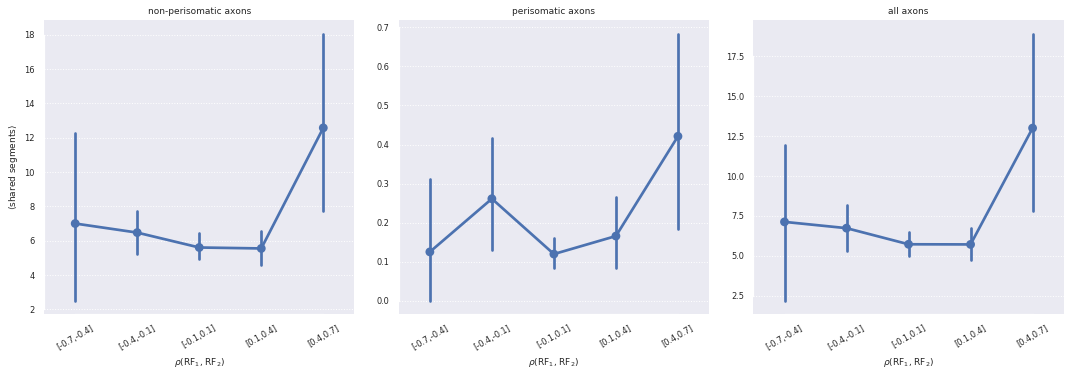

In [237]:
"""
Plots 3 different ones of where compares n_seg_shared (y) vs. binned correlation of the receptive field
FOR EACH OF THE POSTSYN GROUPS
"""
g = sns.catplot('bcorr', 'n_seg_shared', data=cdf, col='connection', kind='point', legend_out=True, sharey=False)
g.set_axis_labels(x_var=r'$\rho$(RF$_1$, RF$_2$)', y_var=r'$\langle$shared segments$\rangle$')

for ax in g.axes.ravel():
    ax.yaxis.grid(True, linestyle=':')
    ax.set_xticklabels(cbin_labels, rotation=30)
sns.despine(trim=True)
g.set_titles('{col_name} axons')

g.fig.savefig('figures/average_shared_input_vs_correlation.png', dpi=200)
g.fig.savefig('figures/average_shared_input_vs_correlation.pdf')

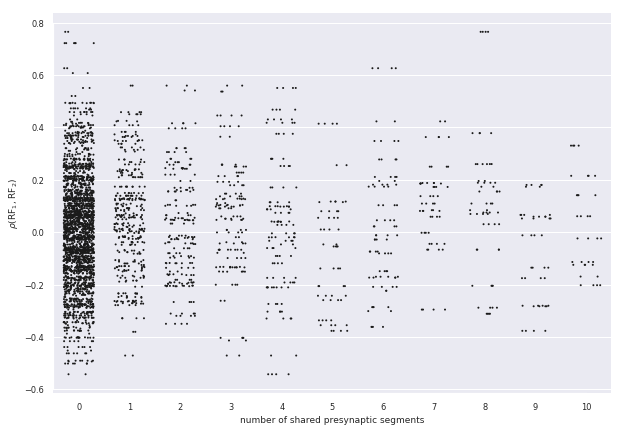

In [238]:
"""
Strip plot is a way of grouping data and ploting them along a continuous value 
- jitter just helps spread out the data points

Conclusion what it graphs:
1) Takes all of the data with number of shared segments less than 11 
and plots the rf correlation coefficiet for those groups

"""
g = sns.stripplot( 'n_seg_shared', 'rf_corr_coef', data=cdf[cdf.n_seg_shared < 11], jitter=0.3, s=2, color='k')
g.set_xlabel(r'number of shared presynaptic segments')
g.set_xticklabels([int(e) for e in g.get_xticks()])
g.set_ylabel(r'$\rho$(RF$_1$, RF$_2$)')
sns.despine(trim=True)
g.figure.set_size_inches((10,7))
g.figure.savefig('figures/shared_input_stripplot.png', dpi=200)
g.figure.savefig('figures/shared_input_stripplot.pdf')

In [239]:
"""
Only gets the data where the difference in orientation is greater than 70 and rf correlation is greater than 40
"""
neg90 = cdf[(cdf.dori > 70/180*np.pi) & (cdf.rf_corr_coef > .40)]
neg90

,segment_a,connection,segment_b,n_seg_shared,segmentation,dummy,scan_idx,rf_corr_coef,ori_1,ori_2,bcorr,dori,bdori
870,81578447,all,110137680,0.0,1,2,3,0.493886,3.27333,1.63936,0.56,1.507623,78.75
871,81578447,non-perisomatic,110137680,0.0,1,2,3,0.493886,3.27333,1.63936,0.56,1.507623,78.75
872,81578447,perisomatic,110137680,0.0,1,2,3,0.493886,3.27333,1.63936,0.56,1.507623,78.75
1350,53349510,all,48234238,3.0,1,3,4,0.445472,1.56219,6.13613,0.56,1.432347,78.75
1351,53349510,perisomatic,48234238,0.0,1,3,4,0.445472,1.56219,6.13613,0.56,1.432347,78.75
1352,53349510,non-perisomatic,48234238,3.0,1,3,4,0.445472,1.56219,6.13613,0.56,1.432347,78.75
1380,53349510,non-perisomatic,107860456,1.0,1,3,3,0.458215,1.56219,3.16470,0.56,1.539083,78.75
1381,53349510,perisomatic,107860456,0.0,1,3,3,0.458215,1.56219,3.16470,0.56,1.539083,78.75
1382,53349510,all,107860456,1.0,1,3,3,0.458215,1.56219,3.16470,0.56,1.539083,78.75
1413,53349510,all,99210911,0.0,1,3,3,0.492442,1.56219,6.18547,0.56,1.481687,78.75


In [240]:
#gets the mean of the rf ofr 2 segments in each one
neg90 = [rf.mean(axis=0) for rf in (nda.RF() & 'segment_id in (53349510, 39500491)').fetch('rf')]
neg0 = [rf.mean(axis=0) for rf in (nda.RF() & 'segment_id in (107860456, 39500491)').fetch('rf')]
pos0 = [rf.mean(axis=0) for rf in (nda.RF() & 'segment_id in (83286327, 5386310)').fetch('rf')]
pos90 = [rf.mean(axis=0) for rf in (nda.RF() & 'segment_id in (53349510, 99210911)').fetch('rf')]

In [253]:
neg90[0].shape,neg90[1].shape

((90, 160), (90, 160))

In [241]:
#groups the pairs by the binned directional orientation and gets the mean of the number of shared segments
df2  = cdf
df2 = df2.groupby(['bdori', 'bcorr'])['n_seg_shared'].mean().reset_index()

In [242]:
cdf[cdf.segment_a==10914339][cdf.segment_b==3152488]

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


,segment_a,connection,segment_b,n_seg_shared,segmentation,dummy,scan_idx,rf_corr_coef,ori_1,ori_2,bcorr,dori,bdori
66,10914339,perisomatic,3152488,0.0,1,2,6,0.091878,3.13328,3.06741,-0.0,0.06587,11.25
67,10914339,all,3152488,1.0,1,2,6,0.091878,3.13328,3.06741,-0.0,0.06587,11.25
68,10914339,non-perisomatic,3152488,1.0,1,2,6,0.091878,3.13328,3.06741,-0.0,0.06587,11.25


In [243]:
cdf[cdf.segment_a==3152488][cdf.segment_b==10914339]

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


,segment_a,connection,segment_b,n_seg_shared,segmentation,dummy,scan_idx,rf_corr_coef,ori_1,ori_2,bcorr,dori,bdori
3996,3152488,non-perisomatic,10914339,1.0,1,6,2,0.091878,3.06741,3.13328,-0.0,0.06587,11.25
3997,3152488,perisomatic,10914339,0.0,1,6,2,0.091878,3.06741,3.13328,-0.0,0.06587,11.25
3998,3152488,all,10914339,1.0,1,6,2,0.091878,3.06741,3.13328,-0.0,0.06587,11.25


In [256]:
neg90

[array([[  -68.6623148 ,   889.57346246,  1950.00384573, ...,
         -2168.19355242, -1574.68656608,  -986.62738609],
        [ -392.13041437,   512.6221345 ,  1619.51390175, ...,
         -2921.83599339, -2029.42859199, -1301.88744707],
        [ -748.65264931,   131.12243531,  1050.99630348, ...,
         -3403.96379373, -2552.29729579, -1534.41305357],
        ...,
        [ -450.9878421 ,   286.45641022,  1046.79137846, ...,
         -2043.97337763, -1662.21974617, -1197.2862086 ],
        [ -436.03660168,   490.05526347,  1369.48324213, ...,
         -2064.02010505, -1600.88909013, -1169.84180759],
        [ -165.60526539,   760.63150822,  1759.43689805, ...,
         -2024.19428574, -1508.52004372,  -987.47265331]]),
 array([[ 2194.35301477,  2005.02425767,   938.13463005, ...,
         -1581.26008686,  -189.11818443,  1356.68300276],
        [ 2248.72868974,  2118.92289588,  1260.53495244, ...,
         -1782.45977533,  -161.00727004,  1386.42600448],
        [ 1264.04321098, 

(90, 160)
(90, 160)
(90, 160)
(90, 160)
(90, 160)
(90, 160)
(90, 160)
(90, 160)


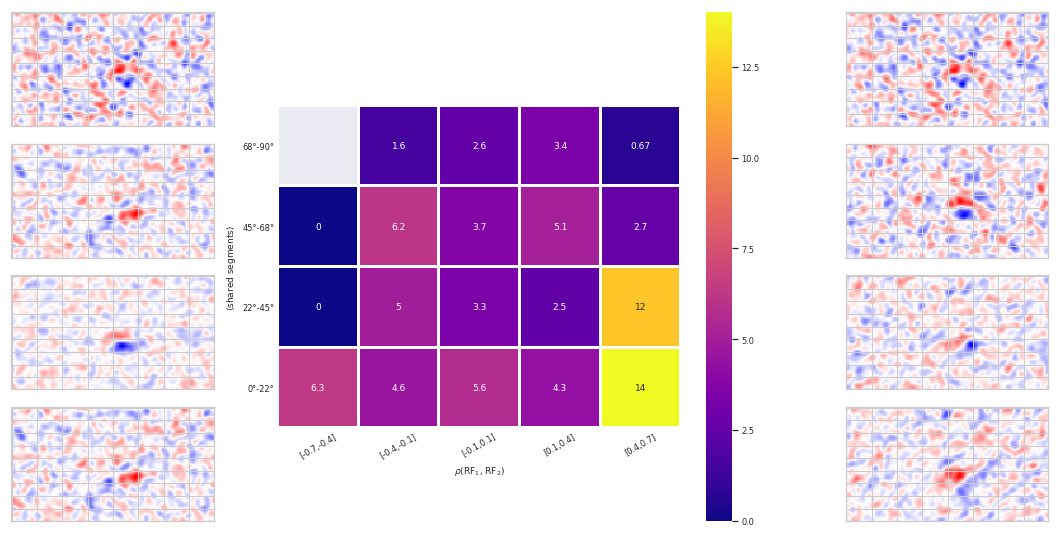

In [257]:
from itertools import chain
gs = plt.GridSpec(4, 4) #specifies geometry of a grid that subplot can be placed on 
fig = plt.figure(figsize=(15,7.5)) #defines size of the figure
ax_heat = fig.add_subplot(gs[:,1:3]) #blocks off the middle two columns for the heat map
with sns.axes_style('whitegrid'):
    ax_tl = [fig.add_subplot(gs[0,0]), fig.add_subplot(gs[1,0])]
    ax_tr = [fig.add_subplot(gs[0,-1]), fig.add_subplot(gs[1,-1])]
    ax_br = [fig.add_subplot(gs[-2,-1]), fig.add_subplot(gs[-1,-1])]
    ax_bl = [fig.add_subplot(gs[-2,0]), fig.add_subplot(gs[-1,0])]

#the chain function just puts all of them together into one iterable
for tl, rf in chain(zip(ax_tl, neg90), zip(ax_bl, neg0), zip(ax_br, pos0),  zip(ax_tr, pos90)):
    print(rf.shape)
    rf -= rf.mean()
    v = np.abs(rf).max()
#     tl.contour(rf, cmap='bwr', levels=np.linspace(-v,v,7))
    tl.matshow(rf, cmap='bwr', vmin=-v, vmax=v)
    tl.set_xticklabels([])
    tl.set_yticklabels([])
    tl.tick_params(axis='both', length=0, width=0)


#doing the actual heat map

#groups the pairs by the binned directional orientation and gets the mean of the number of shared segments
df2  = cdf
df2 = df2.groupby(['bdori', 'bcorr'])['n_seg_shared'].mean().reset_index()
#turns the pairs into a pivot table that can be visualized as a heatmap
df2 = df2.pivot('bdori', 'bcorr', 'n_seg_shared')
#graphs the heat map
g = sns.heatmap(df2, square=True, cmap='plasma', annot=True, linewidths=2, ax=ax_heat)
#applys the y labels for the shared segments (have to format it so they will show the degrees)
g.set_yticklabels(['{}°-{}°'.format(*a) for a in bin_labels], rotation=0)
#sets the rf labels and rotates them slightly
g.set_xticklabels(cbin_labels, rotation=30)
#inverts the y axis so that they are going up in value as graph goes up
g.invert_yaxis()
#sets no tick marks
g.tick_params(length=0)
#set labels
g.set_xlabel(r'$\rho$(RF$_1$, RF$_2$)')
g.set_ylabel(r'$\langle$shared segments$\rangle$')

fig.subplots_adjust(wspace=.01, hspace=.01)
fig.tight_layout()
g.figure.savefig('figures/corr_vs_shared_input_heatmap.png', dpi=200)
g.figure.savefig('figures/corr_vs_shared_input_heatmap.pdf')


In [245]:
cdf[cdf.segment_a < cdf.segment_b][cdf.connection == "all"]

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


,segment_a,connection,segment_b,n_seg_shared,segmentation,dummy,scan_idx,rf_corr_coef,ori_1,ori_2,bcorr,dori,bdori
2,10914339,all,110137680,5.0,1,2,3,0.116995,3.13328,1.639360,-0.00,1.493920,78.75
4,10914339,all,57781491,3.0,1,2,4,0.214111,3.13328,0.445190,0.28,0.453503,33.75
6,10914339,all,93259520,34.0,1,2,4,-0.413310,3.13328,5.427040,-0.28,0.847833,56.25
10,10914339,all,18833086,59.0,1,2,5,-0.301073,3.13328,5.895230,-0.28,0.379643,11.25
13,10914339,all,61375585,4.0,1,2,3,0.467796,3.13328,2.366530,0.56,0.766750,33.75
16,10914339,all,22430215,10.0,1,2,4,0.060944,3.13328,5.592590,-0.00,0.682283,33.75
18,10914339,all,53349510,6.0,1,2,3,0.022207,3.13328,1.562190,-0.00,1.570503,78.75
23,10914339,all,67981253,42.0,1,2,2,-0.045263,3.13328,4.891510,-0.00,1.383363,78.75
24,10914339,all,19315505,40.0,1,2,6,0.519891,3.13328,5.618590,0.56,0.656283,33.75
29,10914339,all,99210911,7.0,1,2,3,0.081230,3.13328,6.185470,-0.00,0.089403,11.25


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


Text(490.1727272727271, 0.5, '$\\langle$Number of pairs in bin$\\rangle$')

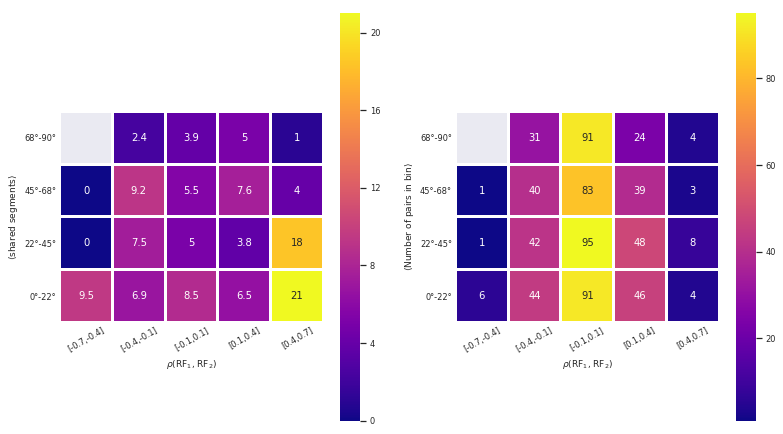

In [246]:
gs = plt.GridSpec(1,2)
fig = plt.figure(figsize=(13,7.5))
ax_heat_shared = fig.add_subplot(gs[0,0])

#groups the pairs by the binned directional orientation and gets the mean of the number of shared segments
#df2  = cdf
df2 = cdf[cdf.segment_a < cdf.segment_b][cdf.connection == "all"]
df2 = df2.groupby(['bdori', 'bcorr'])['n_seg_shared'].mean().reset_index()
#turns the pairs into a pivot table that can be visualized as a heatmap
df2 = df2.pivot('bdori', 'bcorr', 'n_seg_shared')
#graphs the heat map
g = sns.heatmap(df2, square=True, cmap='plasma', annot=True, linewidths=2,ax=ax_heat_shared)
#applys the y labels for the shared segments (have to format it so they will show the degrees)
g.set_yticklabels(['{}°-{}°'.format(*a) for a in bin_labels], rotation=0)
#sets the rf labels and rotates them slightly
g.set_xticklabels(cbin_labels, rotation=30)
#inverts the y axis so that they are going up in value as graph goes up
g.invert_yaxis()
#sets no tick marks
g.tick_params(length=0)
#set labels
g.set_xlabel(r'$\rho$(RF$_1$, RF$_2$)')
g.set_ylabel(r'$\langle$shared segments$\rangle$')

ax_heat_count = fig.add_subplot(gs[0,1])

#groups the pairs by the binned directional orientation and gets the mean of the number of shared segments
df2 = cdf[cdf.segment_a < cdf.segment_b][cdf.connection == "all"]
df2 = df2.groupby(['bdori', 'bcorr'])['n_seg_shared'].count().reset_index()
#turns the pairs into a pivot table that can be visualized as a heatmap
df2 = df2.pivot('bdori', 'bcorr', 'n_seg_shared')
#graphs the heat map
g = sns.heatmap(df2, square=True, cmap='plasma', annot=True, linewidths=2,ax=ax_heat_count,fmt='g')
#applys the y labels for the shared segments (have to format it so they will show the degrees)
g.set_yticklabels(['{}°-{}°'.format(*a) for a in bin_labels], rotation=0)
#sets the rf labels and rotates them slightly
g.set_xticklabels(cbin_labels, rotation=30)
#inverts the y axis so that they are going up in value as graph goes up
g.invert_yaxis()
#sets no tick marks
g.tick_params(length=0)
#set labels
g.set_xlabel(r'$\rho$(RF$_1$, RF$_2$)')
g.set_ylabel(r'$\langle$Number of pairs in bin$\rangle$')



Text(31.5, 0.5, '$\\langle$Number of pairs in bin$\\rangle$')

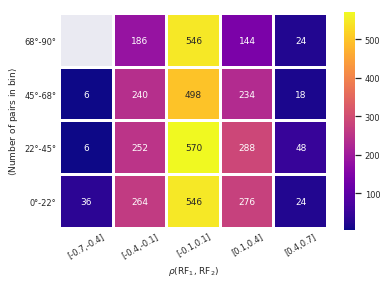

In [247]:
#groups the pairs by the binned directional orientation and gets the mean of the number of shared segments
df2  = cdf
df2 = df2.groupby(['bdori', 'bcorr'])['n_seg_shared'].count().reset_index()
#turns the pairs into a pivot table that can be visualized as a heatmap
df2 = df2.pivot('bdori', 'bcorr', 'n_seg_shared')
#graphs the heat map
sns.set(font_scale=0.75)
g = sns.heatmap(df2, square=True, cmap='plasma', annot=True, linewidths=2,fmt='g')
#applys the y labels for the shared segments (have to format it so they will show the degrees)
g.set_yticklabels(['{}°-{}°'.format(*a) for a in bin_labels], rotation=0)
#sets the rf labels and rotates them slightly
g.set_xticklabels(cbin_labels, rotation=30)
#inverts the y axis so that they are going up in value as graph goes up
g.invert_yaxis()
#sets no tick marks
g.tick_params(length=0)
#set labels
g.set_xlabel(r'$\rho$(RF$_1$, RF$_2$)')
g.set_ylabel(r'$\langle$Number of pairs in bin$\rangle$')


In [248]:
df2

bcorr,-0.56,-0.28,-0.00,0.28,0.56
bdori,,,,,
11.25,36.0,264.0,546.0,276.0,24.0
33.75,6.0,252.0,570.0,288.0,48.0
56.25,6.0,240.0,498.0,234.0,18.0
78.75,NaN,186.0,546.0,144.0,24.0


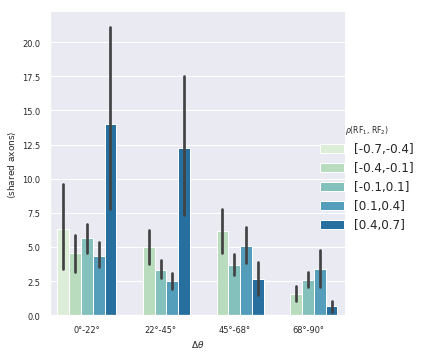

In [249]:
"""
Pulls from the cdf table
Plots the binned difference in orientation (x) vs. average number of shared segments
makes the hue the binned correlation 

but does dso from the cdf so it has to perform the point calculation a nd includes a distribution bar



"""
g = sns.catplot('bdori', 'n_seg_shared', hue='bcorr', kind='bar', palette=sns.color_palette('GnBu', n_colors=5), data=cdf, legend=False)
g.add_legend(prop={'size':12})
g.set_axis_labels(x_var=r'$\Delta \theta$', y_var=r'$\langle$shared axons$\rangle$')
g.set_xticklabels(['{}°-{}°'.format(*a) for a in bin_labels], rotation=0)
new_labels = cbin_labels
g._legend.set_title(r'$\rho$(RF$_1$, RF$_2$)')
for t, l in zip(g._legend.texts, new_labels): 
    t.set_text(l)

sns.despine()
g.fig.savefig('figures/corr_vs_shared_input_bar.png', dpi=200)
g.fig.savefig('figures/corr_vs_shared_input_bar.pdf')

In [255]:
RFCorrelation.Pair.describe()

-> RFCorrelation
-> SegmentRF
-> SegmentRF.proj(other_seg="segment_id")
---
rf_corr_coef         : float                        # correlation coefficient between two cells



'-> RFCorrelation\n-> SegmentRF\n-> SegmentRF.proj(other_seg="segment_id")\n---\nrf_corr_coef         : float                        # correlation coefficient between two cells\n'